In [658]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
import matplotlib.pyplot as plt


In [659]:
# Vectorized (per-step) discrete-time delta hedging (pricing vol vs realized vol)
import numpy as np
from scipy.stats import norm

RV = 0.2
IV = 0.1

def simulate_delta_hedge_paths(
    S0=100.0,
    K=100.0,
    r=0,
    sigma_real=RV,
    sigma_imp=IV,
    T=1.0,
    n_steps=365*5,  # number of hedge rebalances (time intervals). There will be n_steps price increments.
    n_paths=10000,
    seed=None,
    transaction_cost_bps=0.0,
):
    sigma_imp = sigma_real if sigma_imp is None else sigma_imp

    rng = np.random.default_rng(seed)
    dt = T / n_steps

    # Initial price & delta
    sqrt_T = np.sqrt(T)
    d1_0 = (np.log(S0 / K) + (r + 0.5 * sigma_imp**2) * T) / (sigma_imp * sqrt_T)
    d2_0 = d1_0 - sigma_imp * sqrt_T
    call_premium = S0 * norm.cdf(d1_0) - K * np.exp(-r * T) * norm.cdf(d2_0)
    # To hedge a long call (positive delta), we must short the underlying.
    # The stock position will therefore be negative.
    delta = np.zeros(n_steps)
    drift = (r-0.5*sigma_real*sigma_real)
    delta[0] = norm.cdf(d1_0)
    S = np.zeros(n_steps)
    S[0] = S0
    
    gamma = np.zeros(n_steps)
    theta = np.zeros(n_steps)
    gamma[0] = norm.pdf(d1_0)/(S0*sigma_imp*sqrt_T)
    theta[0] = -(S0*norm.pdf(d1_0)*sigma_imp)/(2*sqrt_T) - r*K*np.exp(-r*T)*norm.cdf(d2_0)
    
    cash_account = np.zeros(n_steps)
    cash_account[0] = delta[0] * S0 - call_premium

    gamma_pnl = np.zeros(n_steps)
    theta_pnl = np.zeros(n_steps)

    tau = T

    Z = rng.standard_normal(size=n_steps-1)

    for i in range(n_steps-1):
        S[i+1] = S[i] * np.exp(drift*dt + sigma_real * np.sqrt(dt) * Z[i])
        
        tau -= dt
        d1_0 = (np.log(S[i+1] / K) + (r + 0.5 * sigma_imp**2) * tau) / (sigma_imp * np.sqrt(tau))
        
        delta[i+1] = norm.cdf(d1_0)
        gamma[i+1] = norm.pdf(d1_0)/(S[i+1]*sigma_imp*np.sqrt(tau))
        theta[i+1] = -(S[i+1]*norm.pdf(d1_0)*sigma_imp)/(2*np.sqrt(tau)) - r*K*np.exp(-r*tau)*norm.cdf(d1_0 - sigma_imp*np.sqrt(tau))

        cash_account[i+1] = cash_account[i] * np.exp(r * dt) # financing
        cash_account[i+1] += (delta[i+1] - delta[i]) * S[i+1] #rebalance to be delta hedged
        
        gamma_pnl[i] = 0.5 * gamma[i] * (S[i+1]-S[i])**2
        theta_pnl[i] = theta[i] * dt

    payoff = max(S[-1] - K, 0)
    
    total_pnl = cash_account[-1] - delta[-1] * S[-1] + payoff
    
    return S, delta, call_premium, gamma*dt, total_pnl, cash_account, S, payoff, gamma_pnl, theta_pnl

Total PnL: 1.6960137779746134
Theoretical PnL: 1.6340604932548546


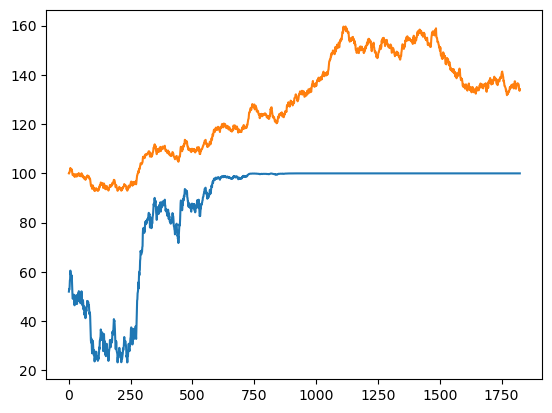

In [660]:
S, delta, call_premium, gamma, total_pnl , cash_account, S, payoff, gamma_pnl, theta_pnl = simulate_delta_hedge_paths()

quantity_traded = np.diff(delta)

plt.plot(100*delta)
plt.plot(S)

pnl_theo = 0.5 * (RV**2 - IV**2) * np.dot(S**2, gamma)

print(f"Total PnL: {total_pnl}")
print(f"Theoretical PnL: {pnl_theo}")

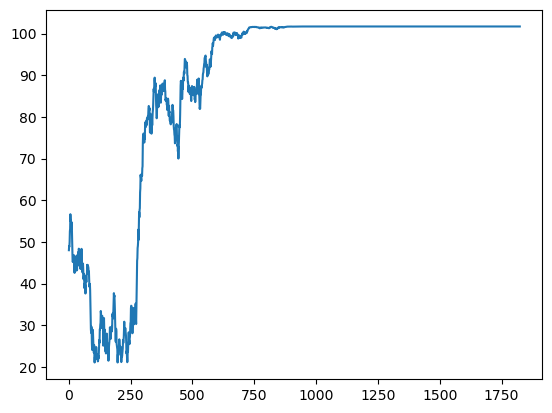

In [661]:
plt.plot(cash_account)

In [662]:
payoff

np.float64(34.216528520559734)

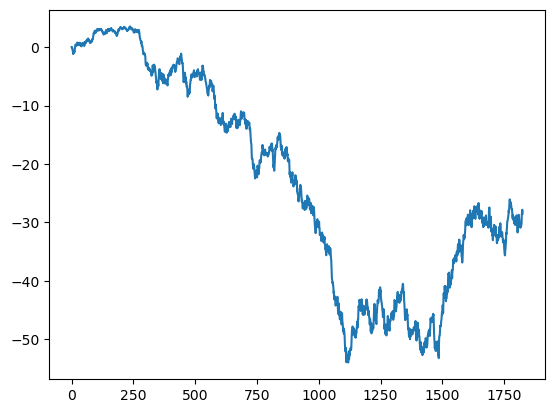

In [663]:
plt.plot(cash_account - delta*S + call_premium)

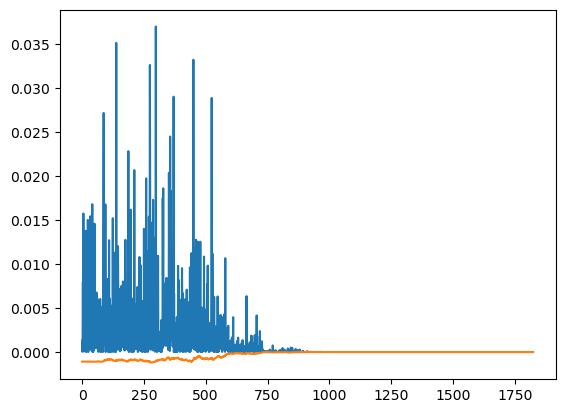

1.702891964516616


In [664]:
plt.plot(gamma_pnl)
plt.plot(theta_pnl)
plt.show()
print(gamma_pnl.sum() + theta_pnl.sum())

#### 1. The P/L of an Idealized *Long* Call Portfolio (Continuous Time)

Let's analyze a portfolio, $\Pi$, that is **long one call option** and is hedged by shorting $\Delta$ shares of the stock.
$$
\Pi = C - \Delta S
$$
The change in this portfolio's value over an infinitesimal time step, $dt$, is:
$$
d\Pi = dC - \Delta dS
$$
This equation tracks the change in value of the assets we *already hold*. Using the Taylor expansion for $dC$ ($dC = \Delta dS + \Theta dt + \frac{1}{2} \Gamma (dS)^2$), we get:
$$
d\Pi = (\Delta dS + \Theta dt + \frac{1}{2} \Gamma (dS)^2) - \Delta dS
$$
$$
d\Pi = \Theta dt + \frac{1}{2} \Gamma (dS)^2
$$
This is the P/L from the existing position, often called the "gamma-theta" P/L. Now, we use the Black-Scholes PDE relationship, which dictates that for the option to be fairly priced (with $r=0$), the time decay must offset the expected gamma earnings: $\Theta = -\frac{1}{2} \sigma_{\text{imp}}^2 S^2 \Gamma$. Substituting this in:
$$
d\Pi = \left(-\frac{1}{2} \sigma_{\text{imp}}^2 S^2 \Gamma\right) dt + \frac{1}{2} \Gamma (dS)^2
$$
Factoring out terms gives the famous result:
$$
d\Pi = \frac{1}{2} \Gamma S^2 \left( \left(\frac{dS}{S}\right)^2 - \sigma_{\text{imp}}^2 dt \right)
$$
In the continuous world, the instantaneous variance $(\frac{dS}{S})^2$ is defined as $\sigma_{\text{real}}^2 dt$. So, the P/L of the idealized portfolio is:
$$
d\Pi = \frac{1}{2} \Gamma S^2 (\sigma_{\text{real}}^2 - \sigma_{\text{imp}}^2) dt
$$
This equation shows that if $\sigma_{\text{real}} = \sigma_{\text{imp}}$, the P/L of a continuously hedged portfolio should be exactly zero.